This code generates a bunch of mixed sinosodal laser profiles, of same magnitude and mean. For testing only.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
from scipy.stats import qmc
from scipy.interpolate import UnivariateSpline
from scipy import signal



warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We create the LHS sampling plan for laser profile features

In [2]:
sampler = qmc.LatinHypercube(d=4)
sample = sampler.random(n=100)

l_bounds = [0, 400, 0, 0]  ## lower bound of Frequency of Laser Power, Mean Laser Power, Variance of Laser Power, and Amplitude of step
u_bounds = [1000, 600, 10, 1] ## upper bound of Frequency of Laser Power, Mean Laser Power, Variance of Laser Power, and Amplitude of step
Initial_sample = qmc.scale(sample, l_bounds, u_bounds)

In [3]:
number_samples = 10
sampling_plan = Initial_sample  ## Import data 
sampling_plan = np.array(sampling_plan)
sampling_plan = sampling_plan[:number_samples,:]
mean_power_value = sampling_plan[:,1]
Variance_laser_power_value = sampling_plan[:,2]
Frequency_value = sampling_plan[:,0]
Amplitude_of_step = sampling_plan[:,3]

data_array = []

for itero in range(0, len(sampling_plan[:number_samples,1])):
    mean_power = mean_power_value[itero]
    Variance_laser_power = Variance_laser_power_value[itero]
    Frequency = int(Frequency_value[itero]) ## Figure this out
    Time_period = int((1/Frequency)*100)

    ## Defining the step function 
    imp = signal.unit_impulse(100)
    b, a = signal.butter(4, 0.2)
    response = -(signal.lfilter(b, a, imp)*Amplitude_of_step[itero])+1

    ## Increasing size of array by interpolating 
    old_indices_response = np.arange(0,len(response))
    new_length_response = Frequency
    new_indices_response = np.linspace(0,len(response)-1,new_length_response)
    spl_response = UnivariateSpline(old_indices_response,response,k=3,s=0)
    data_n_response = spl_response(new_indices_response)


    with pm.Model() as model:
        mu = pm.Normal("mu", mu=mean_power, sigma=Variance_laser_power)

        step1 = pm.Metropolis(vars=[mu])
        idata = pm.sample(Frequency, step=[step1], cores=1, return_inferencedata=True)
    Time = np.linspace(0, 100, Frequency)
    data = np.array(idata.posterior.mu*data_n_response)[0,:]

    data = np.tile(data, int((500*500)/Frequency))
    

    ## Increasing size of array by interpolating 
    old_indices = np.arange(0,len(data))
    new_length = 250000   ## This is the total number of time steps 
    new_indices = np.linspace(0,len(data)-1,new_length)
    spl = UnivariateSpline(old_indices,data,k=3,s=0)
    data_n = spl(new_indices)
    
    data_array.append(data_n)


You can find the C code in this temporary file: /var/folders/9v/0d_myt517fxfgpgxccsw2h0w0000gn/T/theano_compilation_error_ey48k9dy


Exception: ("Compilation failed (return status=1): ld: unsupported tapi file type '!tapi-tbd' in YAML file '/Library/Developer/CommandLineTools/SDKs/MacOSX11.1.sdk/usr/lib/libSystem.tbd' for architecture x86_64. clang: error: linker command failed with exit code 1 (use -v to see invocation). ", 'FunctionGraph(Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{0.267658267032245}))')

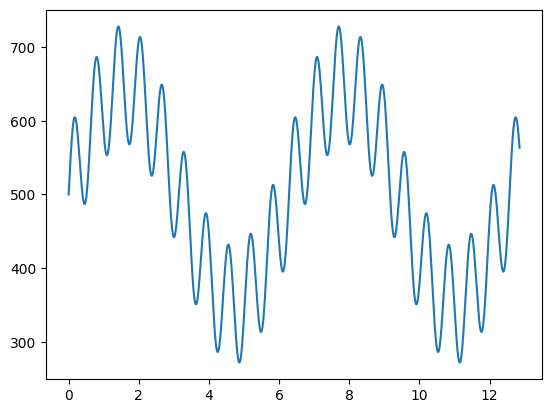

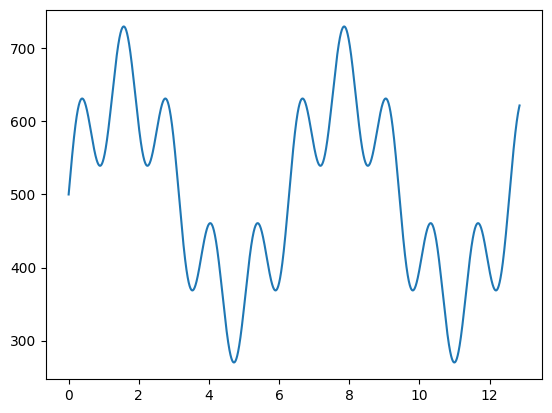

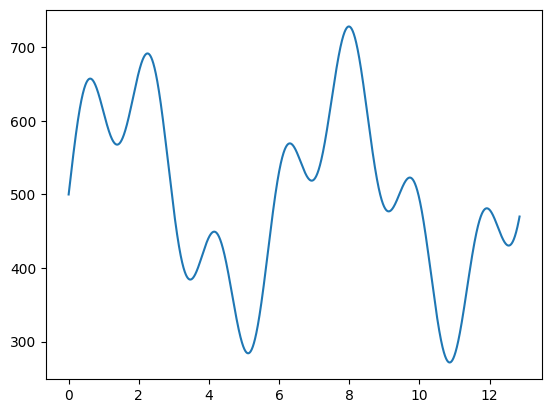

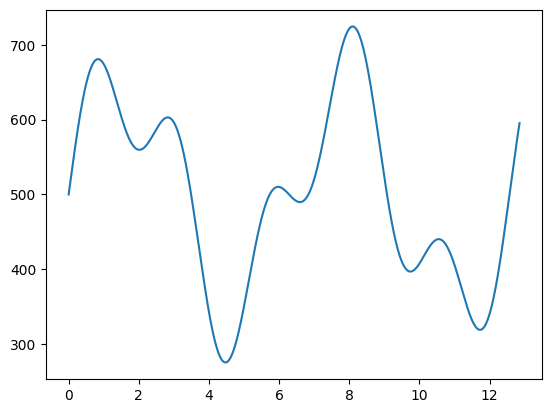

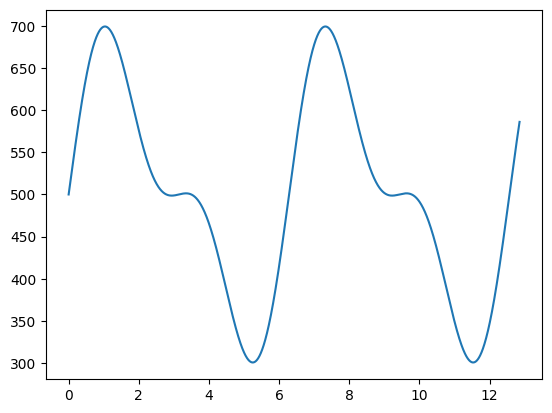

In [8]:
num_datapoints = 6428 # Number of data points to generate
num_profs = 5 # Number of profiles to generate
dt = 0.002

t_vec = np.arange(0, dt*(num_datapoints), dt, dtype=np.float64)
for itr in range(0, num_profs):
    laser_power = 150.*np.sin(t_vec) + 500. + 4*20.*np.sin(10*t_vec/(itr+1))
    fig, ax = plt.subplots()
    ax.plot(t_vec, laser_power)

    out_df = pd.DataFrame({'laser_power': laser_power, 'time_elapsed': t_vec})
    out_df.to_csv("LP_" + str(itr + 1) + ".csv", index=False)
    #print(out_df)